In [31]:
%matplotlib qt

## imports
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import matplotlib
from matplotlib import cm
import h5py
import os
from math import pi, sqrt
from scipy.optimize import curve_fit
import scipy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time
from scipy.interpolate import InterpolatedUnivariateSpline
rc('text', usetex=True)
import seaborn as sns
from os import path

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


## Read and plot GW data

In [2]:
## Data reading functions

def GetWaveformRadius(p, rad):
    psi4_file = p + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5'
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[rad]
    coord_radius = f[radius]['CoordRadius.dat'][0][1]
    return coord_radius
    
def GetPsi4Mode(p, mode, radius=-1): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetStrainMode(p, mode, radius=-1): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rh_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetPsi4ModeExtrapolated(p, mode, order=2): 
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'rMPsi4_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    data = f['Extrapolated_N' + str(order) +'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetStrainModeExtrapolated(p, mode, order=2): 
    l = mode[0]
    m = mode[1]
    h_file = p + 'rhOverM_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(h_file, 'r')
    data = f['Extrapolated_N'+str(order)+'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    h = re + 1j*im
    return time, h

In [38]:
## Data helper functions

def CutTimes(time, data, TLow, TUp): ###
    TLowIndex = np.where(time <= TLow)[0][0]
    TUpIndex = np.where(time >= TUp)[0][-1]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def CutTimesGeodesic(time, x, y, z, lapse, TLow, TUp): ###
    TLowIndex = np.where(time <= TLow)[0][-1]
    TUpIndex = np.where(time >= TUp)[0][0]
    time = time[TLowIndex:TUpIndex]
    x = x[TLowIndex:TUpIndex]
    y = y[TLowIndex:TUpIndex]
    z = z[TLowIndex:TUpIndex]
    lapse = lapse[TLowIndex:TUpIndex]
    return time, x, y, z, lapse

def GetPeakTimeMode(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.absolute(data))]
    return t_peak

def GetPeakTimeModeReal(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.real(data))]
    return t_peak

def SubtractPeakTimeMode(time, data): ###
    t_peak = GetPeakTimeMode(time, data)
    return time - t_peak

def SubtractPeakTimeModeReal(time, data): ###
    t_peak = GetPeakTimeModeReal(time, data)
    return time - t_peak

def InterpolateTimes(time, data, time_dest):
    """ Interpolates time, data onto new time axis
        time_dest """
    interpolant = scipy.interpolate.CubicSpline(time, data)
    return interpolant(time_dest)

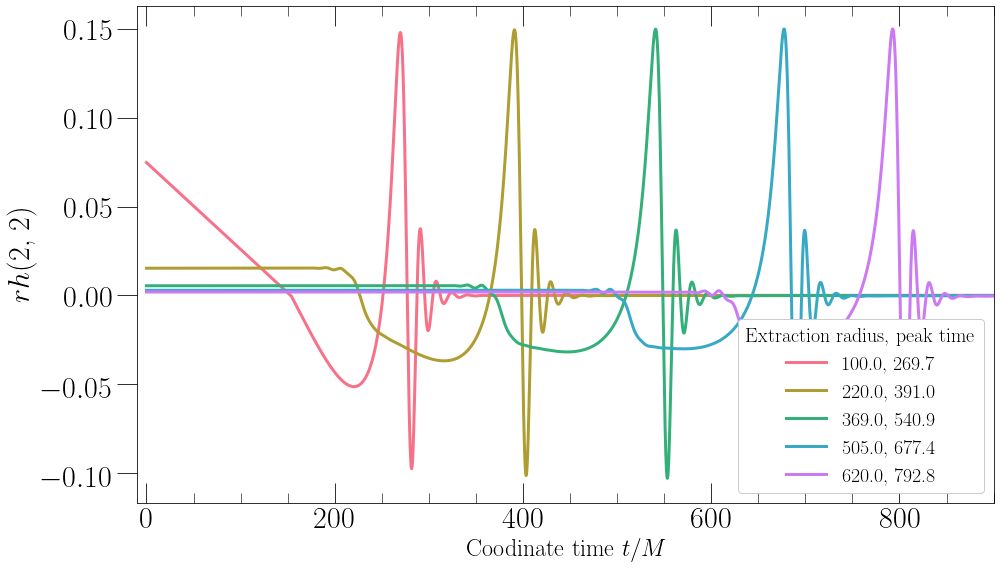

In [6]:
## Plot strain at various radii

def PlotRadiiStrain(p):
    ## Run Progress
    plt.figure(figsize=(14, 8))

    mode = (2,2)
    
    radii = [0, 15, 20, 22, 23]
    cs = sns.color_palette('husl', n_colors=len(radii))

    for rad, i in zip(radii, range(len(radii))):

        radius = int(GetWaveformRadius(p, rad))
        
        time, data = GetStrainMode(p, mode, radius=rad)
        tt = GetPeakTimeMode(time, data)
        
        plt.plot(time, np.real(data), label='%.1f, %.1f' % (radius, tt), color=cs[i])

    plt.xlabel(r'Coodinate time $t/M$')
    plt.ylabel(r'$rh$' + str(mode), fontsize=30)
    legend = plt.legend(loc='lower right', title='Extraction radius, peak time', fontsize=20, framealpha=1.0)
    plt.setp(legend.get_title(),fontsize=20)
    plt.xlim(-10, 900)
    plt.tight_layout()
    plt.savefig('RadiiPeaks.pdf')
    plt.show()
    
#PlotRadiiStrain('Data/HeadOn/JoinedLev1/')
PlotRadiiStrain('Data/HeadOn_Harmonic/JoinedLev2/')

## Plot lensing refinement method results + final positions

In [ ]:
## Plot the vanilla SpEC lensing run results

def PlotRefinementMethodResult(p):
    
    """ Print the results of the vanilla lensing run. For the file structure, we have
    Geo's final time,
    Geo's final position x,
    Geo's final position y,
    Geo's final position z,
    Geo's final 4-momentum t (roughly, redshift),
    Geo's final 4-momentum x,
    Geo's final 4-momentum y,
    Geo's final 4-momentum z"""
    
    
    file = p + '/RefinementMethodData.h5'
    f = h5py.File(file, 'r')
    data = f['GeodesicFinalVars.dat']
    
    x_positions = data[:,1]
    y_positions = data[:,2]
    z_positions = data[:,3]
    
    plt.figure(figsize=(10, 10))
    
    plt.scatter(y_positions, z_positions, color='red', s=10)
    #plt.xlim(-5.0, 5.0)
    #plt.ylim(-5.0, 5.0)

    plt.xlabel(r'Camera X')
    plt.ylabel(r'Camera Y')
    plt.tight_layout()
    plt.savefig('Camera.pdf')
    plt.show()
    
PlotRefinementMethodResult('Data/Kerr')

In [ ]:
## Plot the vanilla SpEC lensing run results

def Plot3DFinalPositions(p):
    
    """ Print the results of the vanilla lensing run. For the file structure, we have
    Geo's final time,
    Geo's final position x,
    Geo's final position y,
    Geo's final position z,
    Geo's final 4-momentum t (roughly, redshift),
    Geo's final 4-momentum x,
    Geo's final 4-momentum y,
    Geo's final 4-momentum z"""

    plt.rcParams['grid.linewidth'] = 0.25
    
    file = p + '/RefinementMethodData.h5'
    f = h5py.File(file, 'r')
    data = f['GeodesicFinalVars.dat']
    
    x_pos = data[:,1]
    y_pos = data[:,2]
    z_pos = data[:,3]
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    
    ax.scatter(x_pos, y_pos, z_pos, color='red', s=10)
    ax.scatter([0.0], [0.0], [100.0], color='black', s = 100)
    ax.quiver([0.0], [0.0], [100.0], [0.0], [0.0], [-10.0], length=20.0, normalize=True, color='black')
    
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    plt.tight_layout()
    plt.savefig('Positions.pdf')
    plt.show()
    
Plot3DFinalPositions('Data/Kerr')


## Read in horizon data and create interpolants
## Read in geodesic trajectories

In [7]:
## Read in horizon trajectories

Lev = "2"

def read_horizon_trajectories(Horizon):
    """ Horizon is a string corresponding to the BH we're interested in [A, B, C]"""
    f = "Data/HeadOn_Harmonic/JoinedLev" + Lev + "/ApparentHorizons/Trajectory_Ah" + Horizon + ".dat"
    t, x, y, z = np.loadtxt(f, comments="#",usecols=([0,1,2,3]),unpack=True)
    return t, x, y, z

## Build the horizon interpolants
t_a, x_a, y_a, z_a = read_horizon_trajectories("A")
spl_x_a = InterpolatedUnivariateSpline(t_a, x_a)
spl_y_a = InterpolatedUnivariateSpline(t_a, y_a)
spl_z_a = InterpolatedUnivariateSpline(t_a, z_a)

t_b, x_b, y_b, z_b = read_horizon_trajectories("B")
spl_x_b = InterpolatedUnivariateSpline(t_b, x_b)
spl_y_b = InterpolatedUnivariateSpline(t_b, y_b)
spl_z_b = InterpolatedUnivariateSpline(t_b, z_b)

t_c, x_c, y_c, z_c = read_horizon_trajectories("C")
t_merger = t_b[-1]
t_ringdown = t_c[0]
spl_x_c = InterpolatedUnivariateSpline(t_c, x_c)
spl_y_c = InterpolatedUnivariateSpline(t_c, y_c)
spl_z_c = InterpolatedUnivariateSpline(t_c, z_c)

def horizon_at_time(time, Horizon):
    if Horizon == "A":
        return spl_x_a(time), spl_y_a(time), spl_z_a(time)
    if Horizon == "B":
        return spl_x_b(time), spl_y_b(time), spl_z_b(time)
    if Horizon == "C":
        return spl_x_c(time), spl_y_c(time), spl_z_c(time)
    else:
        print("Unrecognized horizon argument")

def min_distance_to_horizon(t, x, y, z):
    """ Returns the minimum distance of a geodesic to a horizon over all time
        t, x, y, z are arrays with the history of the geodesic"""
    min_distance = 1e10
    
    def distance_sqr(xx, yy, zz, xx_h, yy_h, zz_h):
        return (xx - xx_h)**2 + (yy - yy_h)**2 + (zz - zz_h)**2
    
    def distance_to_horizon(time, xx, yy, zz):
        """ Returns the minimum distance to the relevant horizon at given time"""
        min_dist = 1e10
        min_time = 0
        ## look at AhA and AhB before merger
        if time <= t_merger:
            for horizon in ["A", "B"]:
                xx_h, yy_h, zz_h = horizon_at_time(time, horizon)
                dist = distance_sqr(xx, yy, zz, xx_h, xx_h, xx_h)
                min_dist = min(min_dist, dist)
                min_time = time
        ## look at AhC after ringdown
        elif time > t_ringdown:
            xx_h, yy_h, zz_h = horizon_at_time(time, "C")
            dist = distance_sqr(xx, yy, zz, xx_h, xx_h, xx_h)
            min_dist = min(min_dist, dist)
            min_time = time
        return min_dist, min_time
                
    ## minimize over the times
    for time, xx, yy, zz in zip(t, x, y, z):
        
        dist_horizon, dist_time = distance_to_horizon(time, xx, yy, zz)
        min_distance = min(min_distance, dist_horizon)
        #print(time, min_distance)
        
    return(sqrt(min_distance), dist_time)
            

In [6]:
## Functions for reading geodesic positions over time from NodeX.h5 files

def read_geodesic_data(p):
    """ Read in an array of times and positions for all geodesics at once"""
        
    file = p + '/Node0.h5'
    f = h5py.File(file, 'r')
    ## grab the .dat files
    keys = [k for k in f.keys() if 'dat' in k]
    ## Array of times from the .dat files
    times = [float(k.split('.dat')[0]) for k in keys]
    ## sort keys according to times
    times, keys = zip(*sorted(zip(times, keys)))
    times = times[::-1]
    keys = keys[::-1]
    ## grab the number of geodesics
    N_geodesics = len(f[keys[0]][:,0])
    print("Total geodesics: ", N_geodesics, "Time steps: ", len(times))
    ## Minimum index
    m = int(f[keys[0]][:,0][0])
    print("Minimum index of this refinement iteration: ", m)
    
    X = [ [] for _ in range(N_geodesics)]
    Y = [ [] for _ in range(N_geodesics)]
    Z = [ [] for _ in range(N_geodesics)]
    L = [ [] for _ in range(N_geodesics)]
    T = [ [] for _ in range(N_geodesics)]
    
    for k, t in zip(keys, times):
        data = f[k]
        ## indices and positions for all geodesics at this time
        indices = data[:,0]
        l = data[:,1]
        x = data[:,5]
        y = data[:,6]
        z = data[:,7]
        ## fill in the array for each index
        for i, j in zip(indices.astype(int), range(len(indices))):
            X[i-1-m] = np.append(X[i-1-m], x[j])
            Y[i-1-m] = np.append(Y[i-1-m], y[j])
            Z[i-1-m] = np.append(Z[i-1-m], z[j])
            L[i-1-m] = np.append(L[i-1-m], l[j])
            T[i-1-m] = np.append(T[i-1-m], t)
            
    return T, X, Y, Z, L

def MakeGeodesicDatFiles(p):
    print('Reading the geodesic data')
    T, X, Y, Z, L = read_geodesic_data(p)
    print('Read the geodesic data, now printing the files')
    for a in range(len(T)):
        if (len(T[a]) > 100):
            theta = np.arctan2(Z[a], Y[a])
            zero_crossings = np.where(np.diff(np.sign(theta)))[0]
            if (len(zero_crossings) > 3):
                print(a),
                np.savetxt(p + '/Trajectories/' + str(a) + '.dat', np.c_[T[a][::-1],X[a][::-1],
                                                                        Y[a][::-1],Z[a][::-1],L[a][::-1]])

## Functions for reading GetTrajectoriesFromH5 output
def GetGeodesicTrajectory(p, n):
    """ Read in the post-processed trajectory for the nth geodesic """
    f = p + 'Trajectories/' + str(n) + '.dat'
    t, x, y, z, lapse = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4]),unpack=True)
    return t, x, y, z, lapse

def GetGeodesicIndices(p):
    """ Return the indices of all of the geodesics we have printed to file """
    Files = os.listdir(p + '/Trajectories')
    Indices = [int(file.split('.dat')[0]) for file in Files]
    Indices = sorted(Indices)
    return Indices


In [ ]:
MakeGeodesicDatFiles('Data/TraceHeadOn_0_0_100_319.7')

## Plot geodesic trajectories

In [105]:
## Plot the trajectories obtained from the GetTrajectoriesFromH5 executable
def PlotGetTrajectoriesFromH5(p_arr, figname):
    
    def plot_trajectories_file(p, color):
        Indices = GetGeodesicIndices(p)
        Indices = [12237, 11126, 10616, 7766, 20986]
        #Indices = [3, 4042, 9940, 14933, 20224, 25884]
        Indices = [12237]
        for n in Indices:
            t, x, y, z, lapse = GetGeodesicTrajectory(p, n)
            t, x, y, z, lapse = CutTimesGeodesic(t, x, y, z, lapse, 150, 190)
            dtlapse = np.gradient(lapse, t)
            #print(sqrt(y[0]**2 + z[0]**2), x[0])
            #horizon_dist, horizon_time = min_distance_to_horizon(t, x, y, z)
            #theta = np.arctan2(z, y)
            #zero_crossings = np.where(np.diff(np.sign(theta)))[0]
            #if (len(zero_crossings) > 3):
            ax.plot(x, y, z, lw = 0.1, color = 'black')
            #    if (horizon_dist < 2.5):
            #colors = [plt.cm.jet(tt/319) for tt in t]
            ss = ax.scatter(x, y, z, s=10, c=lapse, cmap = 'rainbow') #, vmin=0, vmax=12)
            #ax.plot(x, y, z, c = x, lw = 0.5, label = n) #, color = color) #label = n)
            skip = 2
            #for tt, xx, yy, zz in zip(t[::skip], x[::skip], y[::skip], z[::skip]):
            #    ax.text(xx, yy, zz, str(tt))
        cbar = fig.colorbar(ss, fraction=0.03, pad=0.04,  orientation="horizontal")
        #cbar.set_label(r'$d/dt \log \alpha p_0$', rotation=0)
        cbar.set_label(r'$\log \alpha p_0$', rotation=0)

                
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111, projection='3d')
    
    cs = sns.color_palette('husl', n_colors=len(p_arr))
    for p, i in zip(p_arr, range(len(p_arr))):
        plot_trajectories_file(p, cs[i])
        
    #Add in the horizons
#     for horizon, color in zip(["A", "B", "C"], ["blue", "lightblue", "yellow"]):
#         t_h, x_h, y_h, z_h = read_horizon_trajectories(horizon)
#         #t_h, x_h, y_h, z_h = CutTimesGeodesic(t_h, x_h, y_h, z_h, 155, 180)
#         plt.plot(x_h, y_h, z_h, label="AH " + horizon, color=color, lw = 10.0)
#         if horizon == "C":
#             print(t_h[0])
        
#     u = np.linspace(0, 2*pi, 100)
#     R = 2.03
#     y = R * np.cos(u)
#     z = R * np.sin(u)
#     x = [0.0 for yy in y]
#     plt.plot(x, y, z, lw = 1.0)
    
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    
#     lim = 1.0
#     ax.set_xlim(-lim, lim)
#     ax.set_ylim(-lim, lim)
#     ax.set_zlim(-lim, lim)
    ax.set_axis_off()
    
#     u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
#     R = 2.0292401880333331e+00
#     x = R*np.cos(u)*np.sin(v)
#     y = R*np.sin(u)*np.sin(v)
#     z = R*np.cos(v)
#     #ax.plot_wireframe(x, y, z, color="black", linewidth = 0.1)
    
    #plt.legend()
    plt.tight_layout()
    plt.savefig('Histories_' + figname + '.pdf')
    plt.show()
    


In [106]:
#PlotGetTrajectoriesFromH5(['Data/TraceHeadOn_0_0_100_319.7/'], 'Winding')
PlotGetTrajectoriesFromH5(['Data/TraceHeadOn_0_0_100_319.7/'], 
                          'Winding')
#PlotGetTrajectoriesFromH5(['Data/TraceHeadOn_0_0_100_317.7/', 'Data/TraceHeadOn_0_0_100_319.7/', 'Data/TraceHeadOn_0_0_100_321.7/'], 
#                          'Winding')

## Plot lapse p0

In [27]:
## Plot the trajectories obtained from the GetTrajectoriesFromH5 executable
def PlotLapsep0(p_arr, figname):
    
    def plot_lapse_file(p, color):
        Indices = GetGeodesicIndices(p)
        #Indices = [12237, 11126, 10616, 7766, 20986]
        #Indices = [3, 4042, 9940, 14933, 20224, 25884]
        #Indices = [11231]
        for n in Indices[::10]:
            t, x, y, z, lapse = GetGeodesicTrajectory(p, n)
            
            #dlapse = np.gradient(lapse, t)
            
            plt.plot(t, lapse, lw = 1.0)
            
    fig = plt.figure(figsize=(12,8))
    
    plt.axvline(160.7, ls = '--', color='black', lw = 1.0)
    
    cs = sns.color_palette('husl', n_colors=len(p_arr))
    for p, i in zip(p_arr, range(len(p_arr))):
        plot_lapse_file(p, cs[i])

    plt.xlabel(r'$t/M$')
    plt.ylabel('d/dt Lapse $p_0$')

    plt.legend()
    plt.tight_layout()
    plt.savefig('Histories_' + figname + '.pdf')
    plt.show()
    


No handles with labels found to put in legend.


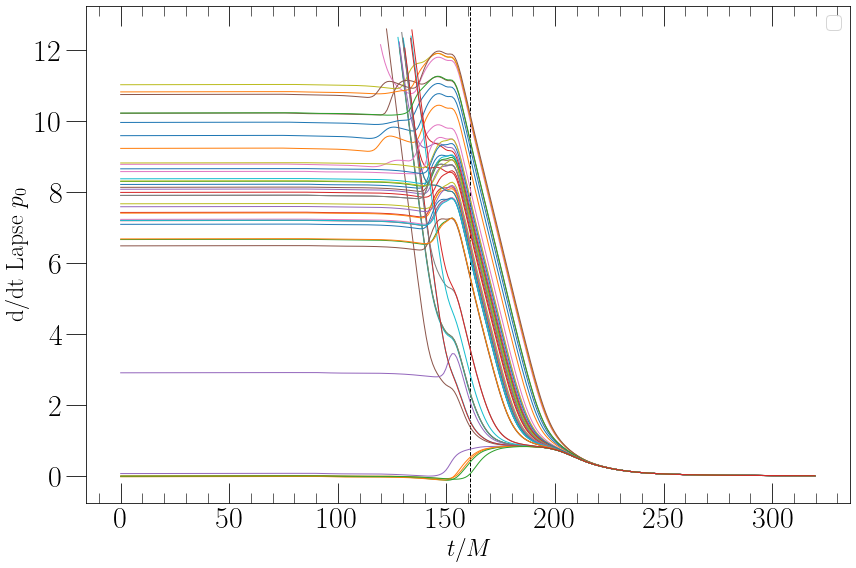

In [28]:
PlotLapsep0(['Data/TraceHeadOn_0_0_100_319.7/'], 
                          'Winding')

In [108]:
## Plot the volume data from ApplyObservers

def GetVolumeData():
    p = '/Users/mokounkova/TracingMerger/Data/HeadOn_Harmonic/JoinedLev2/160.7/'
    X = np.array([])
    Y = np.array([])
    Z = np.array([])
    Data = np.array([])
    for ff in ['Vars_SphereD0.h5', 'Vars_SphereD1.h5']:
        file = p + ff
        f = h5py.File(file, 'r')
        
        x = np.array(f['Coordinates']['Step000000']['x'][:])
        y = np.array(f['Coordinates']['Step000000']['y'][:])
        z = np.array(f['Coordinates']['Step000000']['z'][:])
        data = np.array(f['Psi4']['Step000000']['scalar'][:])
        
        X = np.concatenate((X, x))
        Y = np.concatenate((Y, y))
        Z = np.concatenate((Z, z))
        Data = np.concatenate((Data, data))
    s = 1
    return X[::s], Y[::s], Z[::s], Data[::s]


In [169]:
## Plot the volume data from ApplyObservers

def PlotVolumeData(p):

    def plot_trajectories_file(p):
        Indices = [12237, 11126, 10616, 7766, 20986]
        for n in Indices[::1]:
            t, x, y, z, lapse = GetGeodesicTrajectory(p, n)
            #print(t[1:] - t[:-1])
            t, x, y, z = CutTimesGeodesic(t, x, y, z, 160.7, 161)
            r = sqrt(x**2 + y**2 + z**2)
            #print(r)
            for i in range(len(t)):
                print("Geodesic: ", n, "t: ", t[i], "x: %.4f y: %.4f z: %.4f" % (x[i], y[i], z[i]))
            for tt, xx, yy, zz in zip(t, x, y, z):
                ax.text(xx, yy, zz, str(tt))
            
            t, x, y, z = GetGeodesicTrajectory(p, n)
            #t, x, y, z = CutTimesGeodesic(t, x, y, z, 140, 170)
            ax.plot(x, y, z, lw = 0.5, label = n)

                
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

#     x, y, z, Lapse = GetVolumeData()
#     cb = ax.scatter(x, y, z, c = Lapse, s=10)
#     fig.colorbar(cb)
    
    plot_trajectories_file(p)
        
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    lim = 3.0
#     ax.set_xlim(0.3, 0.5)
#     ax.set_ylim(-2.0, -1.9)
#     ax.set_zlim(0.5, 0.6)
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)


    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    R = 2.063450893388303
    x = R*np.cos(u)*np.sin(v)
    y = R*np.sin(u)*np.sin(v)
    z = R*np.cos(v)
    ax.plot_wireframe(x, y, z, color="r", linewidth = 0.1)

    
    
    ax.set_axis_off()
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    


In [170]:
PlotVolumeData('Data/TraceHeadOn_0_0_100_319.7/')

TypeError: only size-1 arrays can be converted to Python scalars

In [239]:
## Plot the trajectories obtained from the GetTrajectoriesFromH5 executable
def CoordPartials(p):
    
    def PlotGradient(t, X, lab):
        dX = np.gradient(X, t)
        ddX = np.gradient(dX, t)
        plt.plot(t, ddX, '-', label = lab, lw = 1.0, markersize=5)
        
    def PlotGradientSum(t, x, y, z, lab):
        dx = np.gradient(x, t)
        ddx = np.gradient(dx, t)
        
        dy = np.gradient(y, t)
        ddy = np.gradient(dy, t)
        
        dz = np.gradient(z, t)
        ddz = np.gradient(dz, t)
        
        plt.plot(t, ddx**2 + ddy**2, ddz**2)
    
    Indices = [12237, 11126, 10616, 7766, 20986]
    
    plt.figure(figsize=(10, 6))

    plt.xlim(110, 250)
    
        
    for n in Indices:
        t, x, y, z = GetGeodesicTrajectory(p, n)
        #PlotGradient(t, z, "Geodesic no. " + str(n))
        PlotGradientSum(t, x, y, z, "Geodesic no. " + str(n))

    plt.axvline(153.81, color='black', lw=1.0)
    plt.axvline(160.7, color='black', lw=1.0)
    
    plt.xlabel('Coordinate time')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

In [240]:
CoordPartials('Data/TraceHeadOn_0_0_100_319.7/')

No handles with labels found to put in legend.


## Isotropic sphere distribution

No handles with labels found to put in legend.


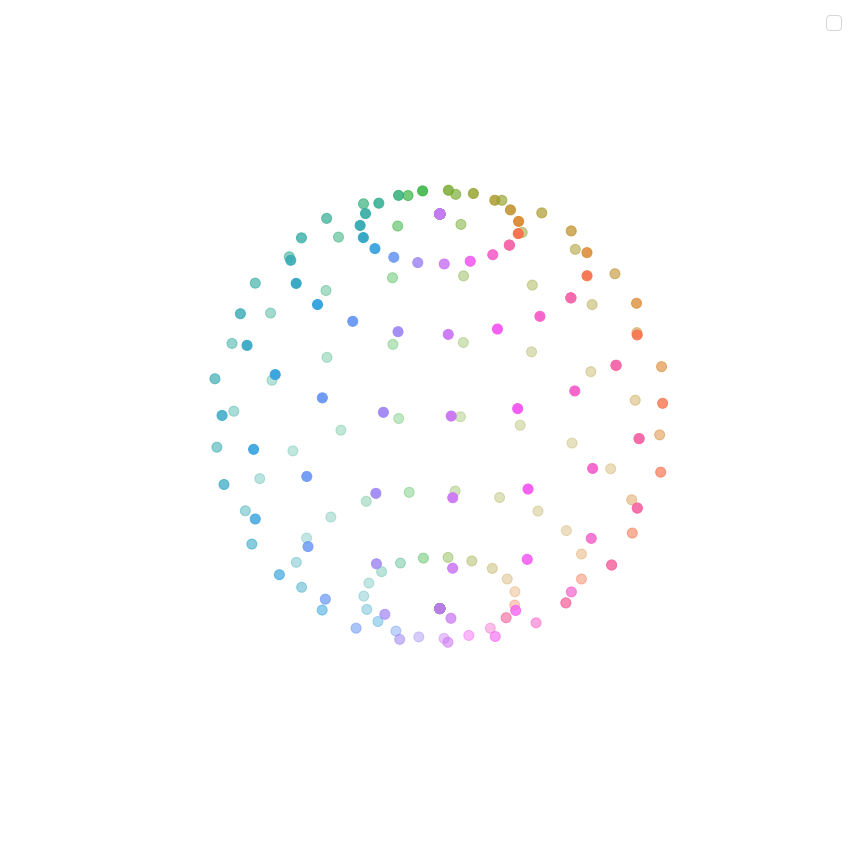

In [56]:
def SpherePlot():
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    
    ## Sphere radius
    R = 100
    
    ## Plot mesh sphere
    u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
    x = R*np.cos(u)*np.sin(v)
    y = R*np.sin(u)*np.sin(v)
    z = R*np.cos(v)
    #ax.plot_wireframe(x, y, z, color="blue", linewidth=0.1)
    
    
    ## Camera coordinates
    theta_points = 10
    phi_points = 20
    
    cs = sns.color_palette('husl', n_colors=phi_points)
    for u, i in zip(np.linspace(0, 2*pi, phi_points), range(phi_points)):
        x = []
        y = []
        z = []
        for v in np.linspace(0, pi, theta_points):
            x.append(R*np.cos(u)*np.sin(v))
            y.append(R*np.sin(u)*np.sin(v))
            z.append(R*np.cos(v))
            #print(int(R*np.cos(u)*np.sin(v)), int(R*np.sin(u)*np.sin(v)), int(R*np.cos(v)))
        ax.scatter(x, y, z, s=100, color=cs[i])
            
            
        
    #u, v = np.mgrid[0:2*np.pi:points, 0:np.pi:points]
    #x = R*np.cos(u)*np.sin(v)
    #y = R*np.sin(u)*np.sin(v)
    #z = R*np.cos(v)
    
    #ax.plot_wireframe(x, y, z, color="b", linewidth=0.1)
    
    
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    ax.set_axis_off()
    lim = 100
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    
    plt.legend()
    plt.tight_layout()
    plt.savefig('Sphere.pdf')
    plt.show()

SpherePlot()

In [137]:
def GetPVDFiles(p):
    """ Return the indices of all of the geodesics we have printed to file """
    Files = os.listdir(p + '/Data')
    Trim = [file.split('_')[1][:5] for file in Files]
    Num = [trim[0] + trim[2:4] + '.' + trim[-1] for trim in Trim]
    return Files, Num

def WritePVDFile(p):
    
    f = open(p + '/Data.pvd', 'w')
    f.write("<VTKFile type=\"Collection\" version=\"0.1\" byte_order=\"LittleEndian\">\n")
    f.write("<Collection>\n")
    
    Files, Num = GetPVDFiles(p)
    for file, num in zip(Files, Num):
        f.write("<DataSet timestep=\"" + num + "\" file=\"Data/"+file+"\" />\n")

    
    f.write("</Collection>\n")
    f.write("</VTKFile>")
    f.close()

In [138]:
p = "Data/HeadOn_Harmonic/JoinedLev2/Paraview"

#GetPVDFiles(p)
WritePVDFile(p)
